# Import libraries

In [1]:
# basemodels
from models import QuantileLinearRegressor, QuantileForestRegressor, QuantileNeuralRegressor
from neuralprophet import NeuralProphet
from arima import ARIMA

# metrics for comparison
from metrics import Metrics

# conformal methods to use
from conformal_methods import ACI, CQR, EnbPI, EnCQR

# data generation and subplots
from utils import SyntheticData, create_subplots, \
train_val_test, split_x_y, compute_aci, optimize_conformal

# data science
import pandas as pd
import numpy as np
from sktime.utils.plotting import plot_series
from sktime.utils import plotting
from tqdm import tqdm
import matplotlib.pyplot as plt

import quantnn
import run_experiment


import torch
import random
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [2]:
param_range = np.linspace(0.002, 1, 500)
param_range

array([0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016, 0.018,
       0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034, 0.036,
       0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052, 0.054,
       0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 , 0.072,
       0.074, 0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088, 0.09 ,
       0.092, 0.094, 0.096, 0.098, 0.1  , 0.102, 0.104, 0.106, 0.108,
       0.11 , 0.112, 0.114, 0.116, 0.118, 0.12 , 0.122, 0.124, 0.126,
       0.128, 0.13 , 0.132, 0.134, 0.136, 0.138, 0.14 , 0.142, 0.144,
       0.146, 0.148, 0.15 , 0.152, 0.154, 0.156, 0.158, 0.16 , 0.162,
       0.164, 0.166, 0.168, 0.17 , 0.172, 0.174, 0.176, 0.178, 0.18 ,
       0.182, 0.184, 0.186, 0.188, 0.19 , 0.192, 0.194, 0.196, 0.198,
       0.2  , 0.202, 0.204, 0.206, 0.208, 0.21 , 0.212, 0.214, 0.216,
       0.218, 0.22 , 0.222, 0.224, 0.226, 0.228, 0.23 , 0.232, 0.234,
       0.236, 0.238, 0.24 , 0.242, 0.244, 0.246, 0.248, 0.25 , 0.252,
       0.254, 0.256,

In [3]:
dataset = "eurostox"

In [4]:
df, df_train, df_val, df_test, T, tvt_split = run_experiment.get_data(dataset)

In [5]:
quantiles: dict = {"lower": 0.05, "middle": 0.5, "upper" : 0.95}

## New data split

In [6]:
# we currently have train, val, test
# but we want to optimize for a test-independent dataset
# we want to optimize not for the usual df_test but actually for the validation set before
    
# so we first concatenate train and validation set
df_train_val = pd.concat([df_train, df_val])

# then we split it again in train, val, test
# split the data
split = [0.6, 0.2, 0.2]
df_train, df_val, df_test = train_val_test(df_train_val, T=len(df_train_val), tvt_split=split)

In [7]:
df = pd.concat([df_train, df_val, df_test])

In [8]:
T = len(df)

## Linear regression

Define metrics

In [9]:
df_linear = pd.DataFrame({"model_name" : [],
                          "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [10]:
predictions = []  # to store different predictions

Quantile estimation

(3214, 3)


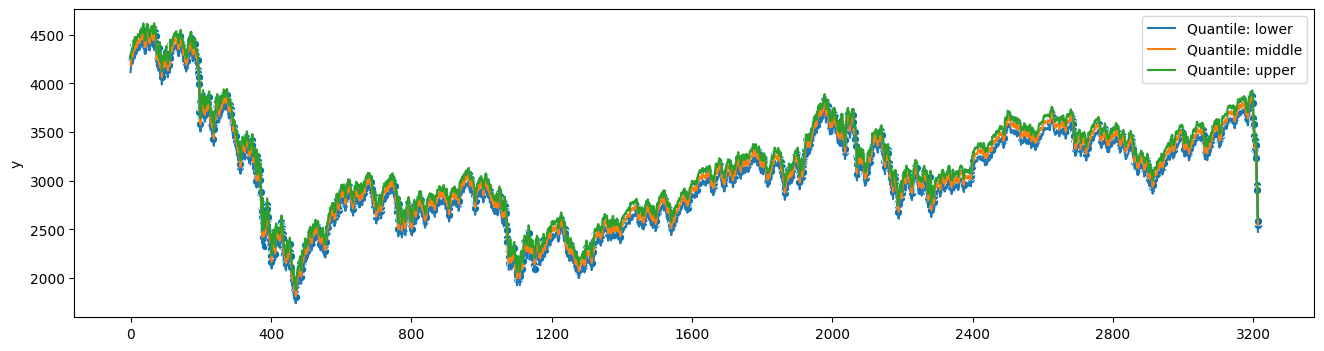

In [11]:
QLR_predictions = {}
        
# fit each prompted quantile and predict on all samples

QLR = QuantileLinearRegressor(quantiles=quantiles.values())
QLR.fit(df_train["y_lag"].to_numpy().reshape(-1,1), 
        df_train["y"].to_numpy())

y_pred = QLR.predict(df["y_lag"].to_numpy().reshape(-1,1))
print(y_pred.shape)

QLR_predictions["lower"] = y_pred[:, 0].reshape(1,-1,1)
QLR_predictions["middle"] = y_pred[:, 1].reshape(1,-1,1)
QLR_predictions["upper"] = y_pred[:, 2].reshape(1,-1,1)


QLR.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], QLR_predictions)

## Quantile Forest

Define metrics

In [12]:
df_forest = pd.DataFrame({"model_name" : [],
                          "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [13]:
predictions = []

Quantile estimation

In [14]:
X_all, y_all = df["y_diff_lag"].to_numpy().reshape(-1,1), df["y_diff"].to_numpy()
X_train, y_train = df_train["y_diff_lag"].to_numpy().reshape(-1,1), df_train["y_diff"].to_numpy()
X_val, y_val = df_val["y_diff_lag"].to_numpy().reshape(-1,1), df_val["y_diff"].to_numpy()
X_test, y_test = df_test["y_diff_lag"].to_numpy().reshape(-1,1), df_test["y_diff"].to_numpy()

In [15]:
QFR = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=[0.05, 0.5, 0.95], max_depth=2, differencing=False)
QFR.fit(X_train, y_train)

In [16]:
y_pred = QFR.predict(X_all)
QFR_predictions = {}

0it [00:00, ?it/s]

3214it [00:20, 160.58it/s]


In [17]:
y_pred.shape

(3214, 3)

In [18]:
QFR_predictions["lower"] = y_pred[:, 0].reshape(1, -1, 1)
QFR_predictions["middle"] = y_pred[:, 1].reshape(1, -1, 1)
QFR_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)

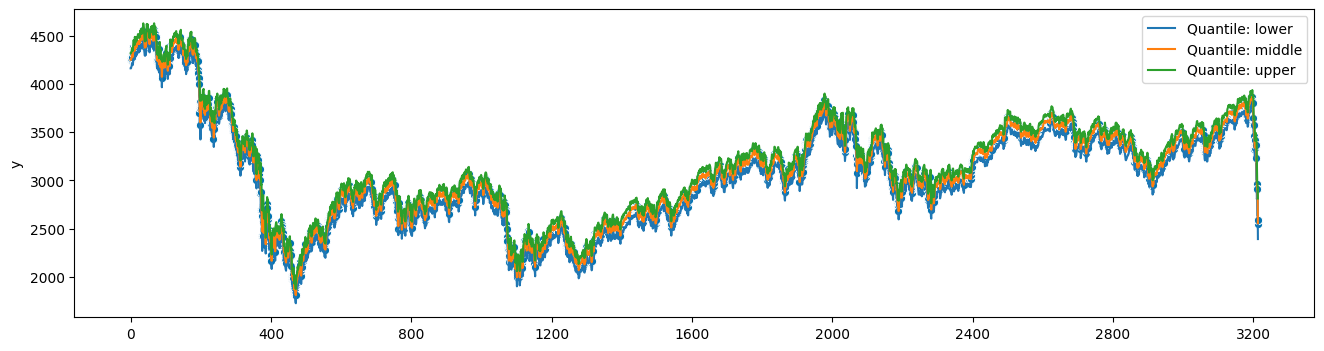

In [19]:
QFR.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], QFR_predictions)

## Neural Regression with QRNN

Define metrics

In [20]:
df_NN = pd.DataFrame({"model_name" : [],
                      "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [21]:
predictions = []

In [22]:
quantiles

{'lower': 0.05, 'middle': 0.5, 'upper': 0.95}

Quantile estimation

In [23]:
layers = 4
neurons = 256
activation = "relu"
model = (layers, neurons, activation)
qrnn = QuantileNeuralRegressor(quantiles=list(quantiles.values()), n_inputs=1, model_params=model)

In [24]:
logs = qrnn.fit(df_train["y_lag"].to_numpy().reshape(-1,1), df_train["y"].to_numpy(), n_epochs=15)

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        916.344       
      2   0.0005        165.933       
      3   0.0005        79.289        
      4   0.0005        38.639        
      5   0.0005        16.709        
      6   0.0005        11.708        
      7   0.0005         9.976        
      8   0.0005         9.392        
      9   0.0005         9.033        
     10   0.0005         9.169        
     11   0.0005        10.061        
     12   0.0005        10.517        
     13   0.0005        11.633        
     14   0.0005        11.068        
     15   0.0005         9.625

In [25]:

y_pred = qrnn.predict(df["y_lag"].values.reshape(-1,1))

NN_predictions = {}
NN_predictions["lower"] = y_pred[:,0].reshape(1, -1, 1)
NN_predictions["middle"] = y_pred[:,1].reshape(1, -1, 1)
NN_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)


[14:06:10] WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun  ]8;id=295630;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=332275;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py#448\448]8;;\
                    for more info.)                                                                                

GRID SEARCH

In [26]:
minimum_lin, scores_lin, gamma_lin = optimize_conformal(param_range=param_range, model_predictions=QLR_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)

[0.002 0.004 0.006 0.008 0.01  0.012 0.014 0.016 0.018 0.02  0.022 0.024
 0.026 0.028 0.03  0.032 0.034 0.036 0.038 0.04  0.042 0.044 0.046 0.048
 0.05  0.052 0.054 0.056 0.058 0.06  0.062 0.064 0.066 0.068 0.07  0.072
 0.074 0.076 0.078 0.08  0.082 0.084 0.086 0.088 0.09  0.092 0.094 0.096
 0.098 0.1   0.102 0.104 0.106 0.108 0.11  0.112 0.114 0.116 0.118 0.12
 0.122 0.124 0.126 0.128 0.13  0.132 0.134 0.136 0.138 0.14  0.142 0.144
 0.146 0.148 0.15  0.152 0.154 0.156 0.158 0.16  0.162 0.164 0.166 0.168
 0.17  0.172 0.174 0.176 0.178 0.18  0.182 0.184 0.186 0.188 0.19  0.192
 0.194 0.196 0.198 0.2   0.202 0.204 0.206 0.208 0.21  0.212 0.214 0.216
 0.218 0.22  0.222 0.224 0.226 0.228 0.23  0.232 0.234 0.236 0.238 0.24
 0.242 0.244 0.246 0.248 0.25  0.252 0.254 0.256 0.258 0.26  0.262 0.264
 0.266 0.268 0.27  0.272 0.274 0.276 0.278 0.28  0.282 0.284 0.286 0.288
 0.29  0.292 0.294 0.296 0.298 0.3   0.302 0.304 0.306 0.308 0.31  0.312
 0.314 0.316 0.318 0.32  0.322 0.324 0.326 0.328 0.33

100%|██████████| 500/500 [22:01<00:00,  2.64s/it]

Example of grid searched results:
--------
['ACI' '34.41952850617399' '0.9968895800933126' '487.6866'
 '0.3694735654569988' '0.4757665814834764']
--------


In [27]:
minimum_rf, scores_rf, gamma_rf = optimize_conformal(param_range=param_range, model_predictions=QFR_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)

[0.002 0.004 0.006 0.008 0.01  0.012 0.014 0.016 0.018 0.02  0.022 0.024
 0.026 0.028 0.03  0.032 0.034 0.036 0.038 0.04  0.042 0.044 0.046 0.048
 0.05  0.052 0.054 0.056 0.058 0.06  0.062 0.064 0.066 0.068 0.07  0.072
 0.074 0.076 0.078 0.08  0.082 0.084 0.086 0.088 0.09  0.092 0.094 0.096
 0.098 0.1   0.102 0.104 0.106 0.108 0.11  0.112 0.114 0.116 0.118 0.12
 0.122 0.124 0.126 0.128 0.13  0.132 0.134 0.136 0.138 0.14  0.142 0.144
 0.146 0.148 0.15  0.152 0.154 0.156 0.158 0.16  0.162 0.164 0.166 0.168
 0.17  0.172 0.174 0.176 0.178 0.18  0.182 0.184 0.186 0.188 0.19  0.192
 0.194 0.196 0.198 0.2   0.202 0.204 0.206 0.208 0.21  0.212 0.214 0.216
 0.218 0.22  0.222 0.224 0.226 0.228 0.23  0.232 0.234 0.236 0.238 0.24
 0.242 0.244 0.246 0.248 0.25  0.252 0.254 0.256 0.258 0.26  0.262 0.264
 0.266 0.268 0.27  0.272 0.274 0.276 0.278 0.28  0.282 0.284 0.286 0.288
 0.29  0.292 0.294 0.296 0.298 0.3   0.302 0.304 0.306 0.308 0.31  0.312
 0.314 0.316 0.318 0.32  0.322 0.324 0.326 0.328 0.33

100%|██████████| 500/500 [20:02<00:00,  2.41s/it]

Example of grid searched results:
--------
['ACI' '34.82859716519041' '0.9968895800933126' '480.2249'
 '0.36382054775875416' '0.48003209163184746']
--------


In [28]:
minimum_nn, scores_nn, gamma_nn = optimize_conformal(param_range=param_range, model_predictions=NN_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)

[0.002 0.004 0.006 0.008 0.01  0.012 0.014 0.016 0.018 0.02  0.022 0.024
 0.026 0.028 0.03  0.032 0.034 0.036 0.038 0.04  0.042 0.044 0.046 0.048
 0.05  0.052 0.054 0.056 0.058 0.06  0.062 0.064 0.066 0.068 0.07  0.072
 0.074 0.076 0.078 0.08  0.082 0.084 0.086 0.088 0.09  0.092 0.094 0.096
 0.098 0.1   0.102 0.104 0.106 0.108 0.11  0.112 0.114 0.116 0.118 0.12
 0.122 0.124 0.126 0.128 0.13  0.132 0.134 0.136 0.138 0.14  0.142 0.144
 0.146 0.148 0.15  0.152 0.154 0.156 0.158 0.16  0.162 0.164 0.166 0.168
 0.17  0.172 0.174 0.176 0.178 0.18  0.182 0.184 0.186 0.188 0.19  0.192
 0.194 0.196 0.198 0.2   0.202 0.204 0.206 0.208 0.21  0.212 0.214 0.216
 0.218 0.22  0.222 0.224 0.226 0.228 0.23  0.232 0.234 0.236 0.238 0.24
 0.242 0.244 0.246 0.248 0.25  0.252 0.254 0.256 0.258 0.26  0.262 0.264
 0.266 0.268 0.27  0.272 0.274 0.276 0.278 0.28  0.282 0.284 0.286 0.288
 0.29  0.292 0.294 0.296 0.298 0.3   0.302 0.304 0.306 0.308 0.31  0.312
 0.314 0.316 0.318 0.32  0.322 0.324 0.326 0.328 0.33

100%|██████████| 500/500 [20:09<00:00,  2.42s/it]

Example of grid searched results:
--------
['ACI' '34.785691328735744' '0.9968895800933126' '487.81494'
 '0.36957078612496513' '0.4756932231874338']
--------


In [29]:
print(gamma_lin)

0.002


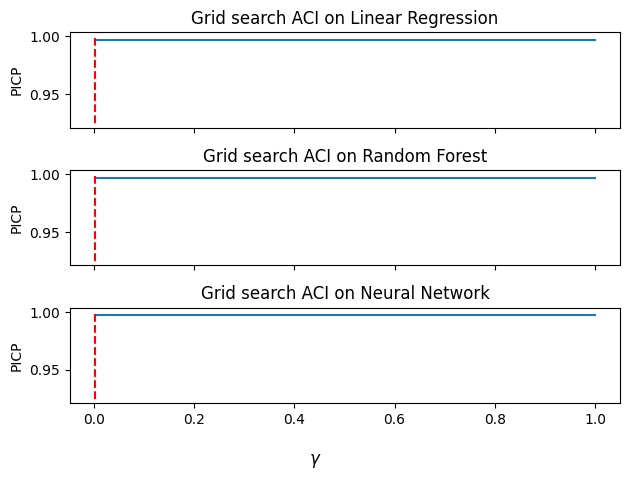

In [30]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
fig.supxlabel('$\gamma$')
model = ['Linear Regression', 'Random Forest', 'Neural Network']
gammas = [gamma_lin, gamma_rf, gamma_nn]
for i, scores in enumerate([scores_lin, scores_rf, scores_nn]):
    ax[i].plot(param_range, scores[:, 2].astype(float).round(3))
    ax[i].set_title(f"Grid search ACI on {model[i]}")
    ax[i].vlines(gammas[i], 0.925, 1, color='red', linestyle='--', label=f'Optimal $\gamma$ = {gammas[i]}')
    ax[i].set_ylabel('PICP')
fig.tight_layout()

In [39]:
scores_lin

array([['ACI', '34.41952850617399', '0.9968895800933126', '487.6866',
        '0.3694735654569988', '0.4757665814834764'],
       ['ACI', '34.41952850617399', '0.9968895800933126', '501.79666',
        '0.3801633998445368', '0.46770051845335187'],
       ['ACI', '34.41952850617399', '0.9968895800933126', '506.4452',
        '0.38368514629082506', '0.4650431686963722'],
       ...,
       ['ACI', '34.41952850617399', '0.9968895800933126', '515.32855',
        '0.3904152210205117', '0.45996496027900097'],
       ['ACI', '34.41952850617399', '0.9968895800933126', '515.32855',
        '0.3904152210205117', '0.45996496027900097'],
       ['ACI', '34.41952850617399', '0.9968895800933126', '515.32855',
        '0.3904152210205117', '0.45996496027900097']], dtype='<U32')

In [31]:
print(gamma_lin, gamma_rf, gamma_nn)

0.002 0.002 0.002


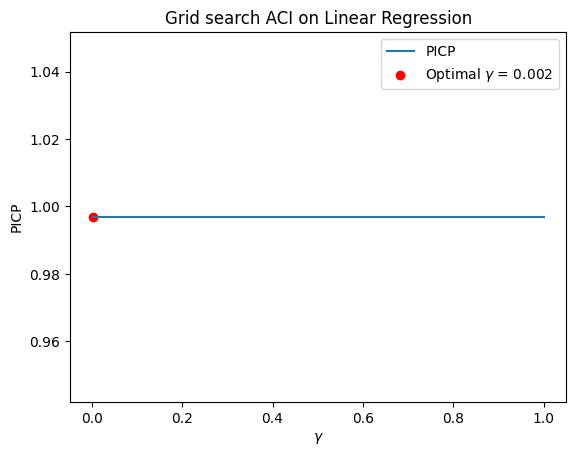

In [32]:
plt.plot(param_range, scores_lin[:, 2].astype(float), label="QLR")
plt.scatter(gamma_lin, scores_lin[np.where(param_range == gamma_lin), 2].astype(float), color="red")
plt.title("Grid search ACI on Linear Regression")
plt.xlabel("$\gamma$")
plt.ylabel("PICP")
plt.legend(["PICP", f"Optimal $\gamma$ = {gamma_lin.round(3)}"])
plt.show()

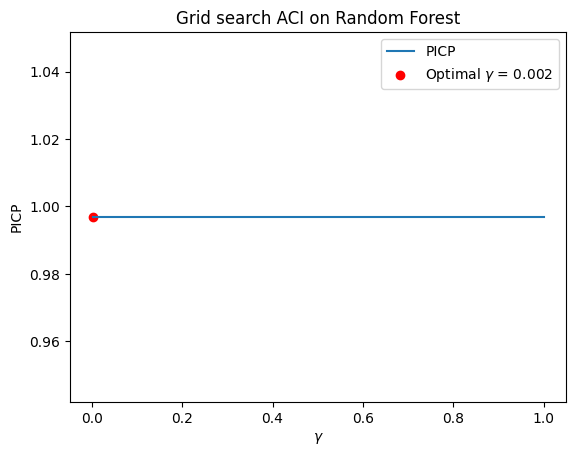

In [33]:
plt.plot(param_range, scores_rf[:, 2].astype(float), label="QLR")
plt.scatter(gamma_rf, scores_rf[np.where(param_range == gamma_rf), 2].astype(float), color="red")
plt.title("Grid search ACI on Random Forest")
plt.xlabel("$\gamma$")
plt.ylabel("PICP")
plt.legend(["PICP", f"Optimal $\gamma$ = {gamma_rf.round(3)}"])
plt.show()

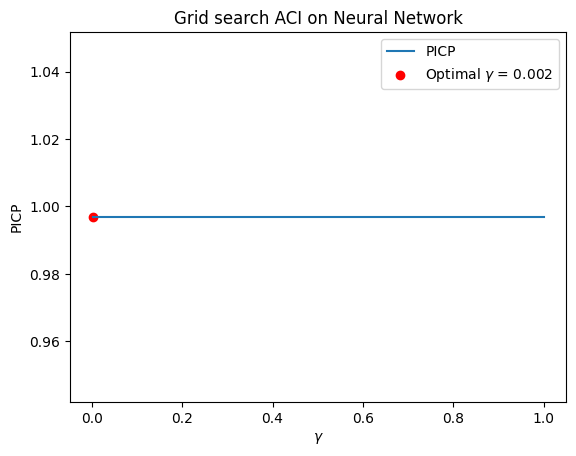

In [34]:
plt.plot(param_range, scores_nn[:, 2].astype(float), label="QLR")
plt.title("Grid search ACI on Neural Network")
plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
plt.xlabel("$\gamma$")
plt.ylabel("PICP")
plt.legend(["PICP", f"Optimal $\gamma$ = {gamma_nn.round(3)}"])
plt.show()

# Conclusion


In [35]:
# we have found the best gamma on the extra test set, now we can evaluate the models on the real test set
# with the best gamma

# then we evaluate whether the intervals are smaller


In [36]:
import pickle

In [37]:
scores = {"linear" : scores_lin, "random_forest" : scores_rf, "neural_network" : scores_nn}


In [38]:
with open("scores_eurostox.pkl", "wb") as f:
    pickle.dump(scores, f)

# Load version

In [39]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
param_range = np.linspace(0.002, 1, 500)
with open("ablations/aci_grid_search/scores.pkl", "rb") as f:
    scores = pickle.load(f)
    
scores_lin = scores["linear"]
scores_rf = scores["random_forest"]
scores_nn = scores["neural_network"]

In [40]:
gamma_lin = param_range[np.argmin(scores_lin[:, 2])]
gamma_rf = param_range[np.argmin(scores_rf[:, 2])]
gamma_nn = param_range[np.argmin(scores_nn[:, 2])]

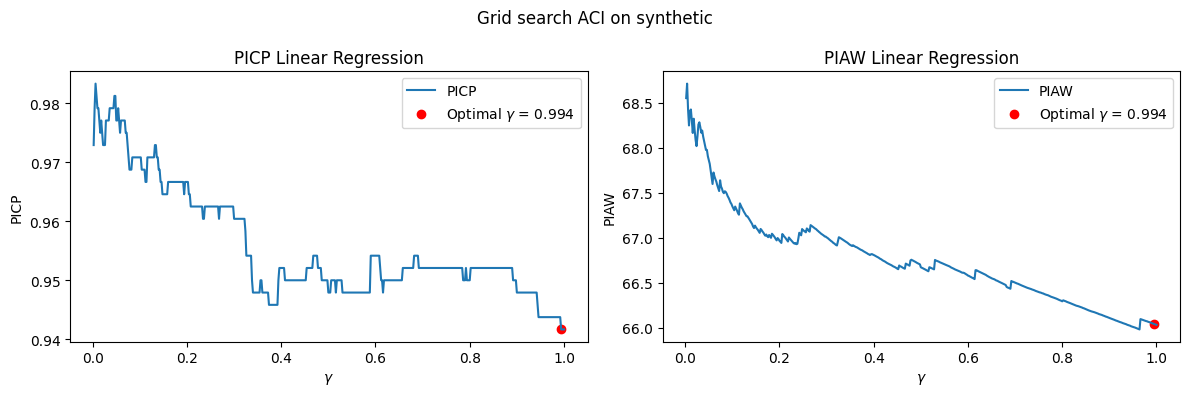

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_size_inches(12, 4
                    )
fig.suptitle("Grid search ACI on synthetic")

# linear regression
ax[1].set_title("PIAW Linear Regression")
ax[1].plot(param_range, scores_lin[:, 3].astype(float), label="QLR")  # piaw 
ax[1].scatter(gamma_lin, scores_lin[np.where(param_range == gamma_lin), 3].astype(float), color="red")
ax[1].set_xlabel("$\gamma$")
ax[1].set_ylabel("PIAW")
ax[1].legend(["PIAW", f"Optimal $\gamma$ = {gamma_lin.round(3)}"])

ax[0].set_title("PICP Linear Regression")
ax[0].plot(param_range, scores_lin[:, 2].astype(float), label="QLR")  # picp
ax[0].scatter(gamma_lin, scores_lin[np.where(param_range == gamma_lin), 2].astype(float), color="red")
ax[0].set_xlabel("$\gamma$")
ax[0].set_ylabel("PICP")
ax[0].legend(["PICP", f"Optimal $\gamma$ = {gamma_lin.round(3)}"])


# # Random forest
# ax[1, 1].set_title("PIAW Random Forest")
# ax[1, 1].plot(param_range, scores_rf[:, 3].astype(float), label="QLR")  # piaw 
# ax[1,1].scatter(gamma_rf, scores_rf[np.where(param_range == gamma_rf), 3].astype(float), color="red")
# ax[1,1].set_xlabel("$\gamma$")
# ax[1,1].set_ylabel("PIAW")
# ax[1,1].legend(["PIAW", f"Optimal $\gamma$ = {gamma_rf.round(3)}"])



# ax[1,0].set_title("PICP Random Forest")
# ax[1,0].plot(param_range, scores_rf[:, 2].astype(float), label="QLR")  # picp
# ax[1,0].scatter(gamma_rf, scores_rf[np.where(param_range == gamma_rf), 2].astype(float), color="red")
# ax[1,0].set_xlabel("$\gamma$")
# ax[1,0].set_ylabel("PICP")
# ax[1,0].legend(["PICP", f"Optimal $\gamma$ = {gamma_rf.round(3)}"])


# # Neural network
# ax[2, 1].set_title("PIAW Neural Network")
# ax[2, 1].plot(param_range, scores_nn[:, 3].astype(float), label="QLR")  # piaw 
# ax[2,1].scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 3].astype(float), color="red")
# ax[2,1].set_xlabel("$\gamma$")
# ax[2,1].set_ylabel("PIAW")
# ax[2,1].legend(["PIAW", f"Optimal $\gamma$ = {gamma_nn.round(3)}"])



# ax[2,0].set_title("PICP Neural Network")
# ax[2,0].plot(param_range, scores_nn[:, 2].astype(float), label="QLR")  # picp
# ax[2,0].scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
# ax[2,0].set_xlabel("$\gamma$")
# ax[2,0].set_ylabel("PICP")
# ax[2,0].legend(["PICP", f"Optimal $\gamma$ = {gamma_nn.round(3)}"])

fig.tight_layout()
plt.show()

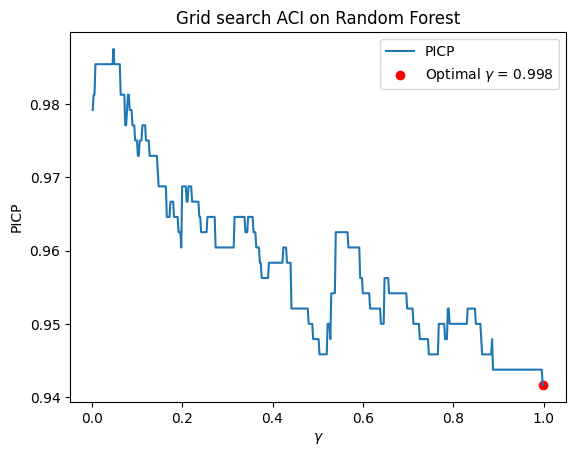

In [42]:
plt.plot(param_range, scores_rf[:, 2].astype(float), label="QLR")
plt.scatter(gamma_rf, scores_rf[np.where(param_range == gamma_rf), 2].astype(float), color="red")
plt.title("Grid search ACI on Random Forest")
plt.xlabel("$\gamma$")
plt.ylabel("PICP")
plt.legend(["PICP", f"Optimal $\gamma$ = {gamma_rf.round(3)}"])
plt.show()

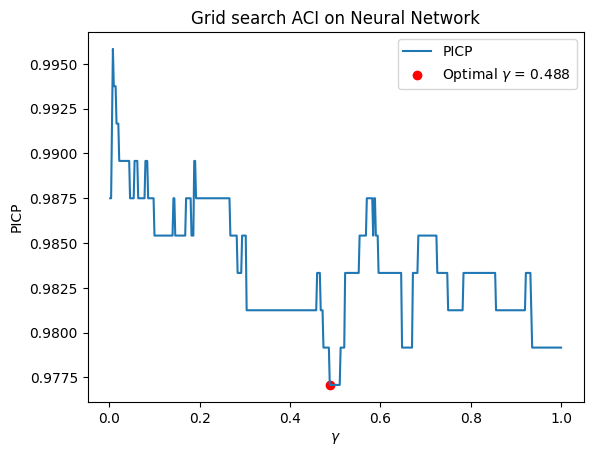

In [43]:
plt.plot(param_range, scores_nn[:, 2].astype(float), label="QLR")
plt.title("Grid search ACI on Neural Network")
plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
plt.xlabel("$\gamma$")
plt.ylabel("PICP")
plt.legend(["PICP", f"Optimal $\gamma$ = {gamma_nn.round(3)}"])
plt.show()